# Conjecture

We see that all roots, when "propagated back" to $t=0$ meet and annihalate each other. We believe that this is the case regardless of the starting conditions

# Overview

1. $H_t(z) := \int_{0}^{\infty}e^{tu^2}\phi (u) \cos (zu) du$
2. $\Phi (u) := \sum_{n=1}^{\infty} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})}$
3. The equations above describe the heatflow of the Riemann Equation.
4. $\exists Λ \in \mathbb{R}$ such that $\forall t \geq Λ$, we have the zeroes of ${H_t}$ being real. This is known as the [de Bruijn–Newman constant](https://en.wikipedia.org/wiki/De_Bruijn%E2%80%93Newman_constant).
5. $Λ \geq 0$ was [proved](https://arxiv.org/pdf/1801.05914.pdf) by Brad Rogers & Terence Tau.
6. $Λ > 0$ is equivalent to the Riemann Hypothesis.
7. $Λ \leq .22$ was [proved](https://github.com/km-git-acc/dbn_upper_bound/blob/master/Writeup/debruijn.pdf) as part of the polimath project.
8. $H_0(z) = \int_0^{\infty}\phi (u) cos(zu) du$ is the Fourier representation of $H_0(z)$

We want to find bounds on $Λ$, following an approach similar to the polymath project

# Plan to bound $Λ$

1. Choose a $t \geq Λ$ ( $t>.2$ suffices for the time being )
2. Take $n$ zeroes $(x_1, x_2, \dots , x_n)$ of $H_t$
3. Computationally estimate how the $x_i$ evolve backwards in time (i.e. towards $t=0$, getting an estimate of the time $t_k$ at which the trajectories of the various $x_i$ converge to a single point
4. Reproduce the above with higher values for $n$, obtaining iteratively better estimates of $Λ$.
5. If
   1. $G \approx 0$, we proved nothing 😢.
   2. $G$ is statistically far from $0$, we have shown that Riemann's Hypothesis is likely true 🎉
  
# Pre-requisites
1. Do we have examples ( in code or books ) of approximating path trajectories using heatflow?
2. What are the best methods known to find zeroes of the Riemann Zeta, i.e. the $(x_1, x_2, ... , x_n)$

# Visualizing $H_t$

We approximate $H_t$ by adding more terms to the sum and approximating the integral. Since the exponential in the integral decreases much faster than the $\Phi$ terms, we can approximate the integral.

We will define a function $h(t,u,z,k)=e^{tu^2} \left [ \sum_{n=1}^{k} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})} \right ] \cos (zu)$, and then approximate the integral over $u$ using QUADPACK

1. $H_t(z) := \int_{0}^{\infty}e^{tu^2}\Phi (u) \cos (zu) du$
2. $\Phi (u) := \sum_{n=1}^{\infty} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})}$

# Imports

In [1]:
import math
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from scipy.integrate import (
    quad,
)  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad
from scipy.optimize import (
    root_scalar,  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar
    fsolve,  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html
)
import itertools
import functools
import multiprocessing
import multiprocessing.pool

In [2]:
sns.set_theme(
    rc={"figure.figsize": (20, 2)}
)  # https://seaborn.pydata.org/generated/seaborn.set_theme.html
pd.set_option("display.float_format", lambda x: f"{x:.2e}")
pd.set_option(
    "display.max_rows", 500
)  # https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.set_option(
    "display.max_columns", 500
)  # https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe

# Aux parallelization

In [3]:
# https://stackoverflow.com/a/57364423
def istarmap(self, func, iterable, chunksize=1):
    self._check_running()
    if chunksize < 1:
        raise ValueError("Chunksize must be 1+, not {0:n}".format(chunksize))

    task_batches = multiprocessing.pool.Pool._get_tasks(func, iterable, chunksize)
    result = multiprocessing.pool.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(
                result._job, multiprocessing.pool.starmapstar, task_batches
            ),
            result._set_length,
        )
    )
    return (item for chunk in result for item in chunk)


multiprocessing.pool.Pool.istarmap = istarmap

In [4]:
# Creates a Pandas Dataframe with a Progress bar using multiprocessing.
# It requires an iterable, columns of the df and a function to calculate
def create_pandas_dataframe(func, iterable, columns, total=None, raw_data=False):

    if total is None:
        total = len(iterable)

    data = []

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        for calculated_row in tqdm(
            pool.istarmap(func=func, iterable=iterable), total=total
        ):
            data.append(calculated_row)

    return pd.DataFrame(data=data, columns=columns)

# Core maths functions

We rearrange the expression for $h_t$ below to avoid overflow errors while calculating exponentials

In [5]:
def h(t, u, z, k):
    return np.product(
        [
            math.pi,
            math.cos(z * u),
            np.sum(
                [
                    (
                        2
                        * math.pi
                        * n**4
                        * math.exp(9 * u + t * u**2 - math.pi * n**3 * math.exp(4 * u))
                        - 3
                        * n**2
                        * math.exp(5 * u + t * u**2 - math.pi * n**2 * math.exp(4 * u))
                    )
                    for n in range(1, k + 1)
                ]
            ),
        ]
    )

In [6]:
def H(t, z, k, b):
    function = lambda u: h(t, u, z, k)
    return quad(func=function, a=0, b=b)

## Checking how the integrand of $H_t(z)$ varies with $b$ and $k$

In [7]:
z_values = np.linspace(-30, 30, 20)
k_values = range(5, 50, 5)
ht = pd.DataFrame(
    [
        {
            "z": z,
            "k": k,
            "root": H(t=0.25, z=z, b=10, k=k)[0],
        }
        for z, k in tqdm(
            itertools.product(z_values, k_values), total=len(z_values) * len(k_values)
        )
    ]
)

  0%|          | 0/180 [00:00<?, ?it/s]

/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


<Axes: xlabel='z'>

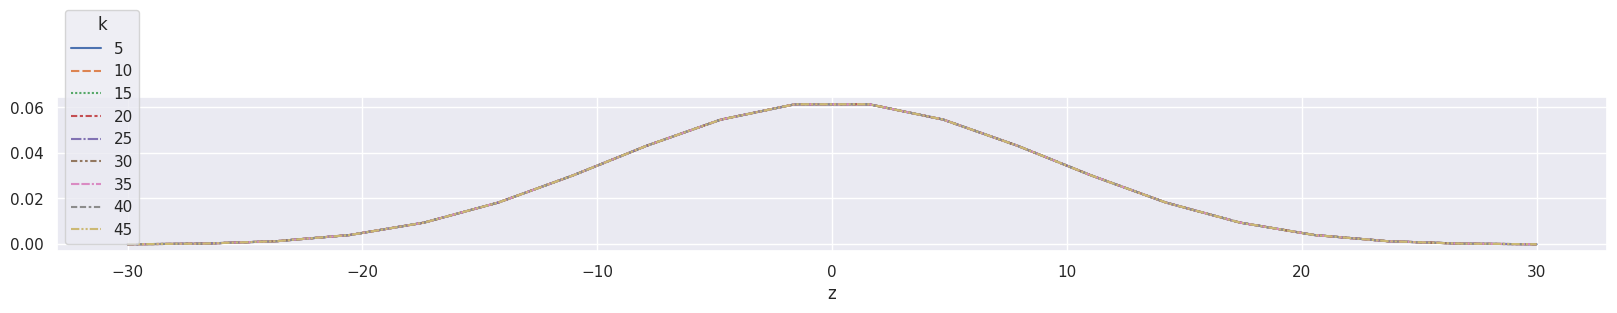

In [8]:
sns.lineplot(data=ht.pivot(index="z", columns="k", values="root"))

In [9]:
z_values = np.linspace(-200, 200, 100)
b_values = range(5, 50, 5)
ht = pd.DataFrame(
    [
        {
            "z": z,
            "b": b,
            "root": H(t=0.25, z=z, b=b, k=5)[0],
        }
        for z, b in tqdm(
            itertools.product(z_values, b_values), total=len(z_values) * len(b_values)
        )
    ]
)

  0%|          | 0/900 [00:00<?, ?it/s]

/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


<Axes: xlabel='z'>

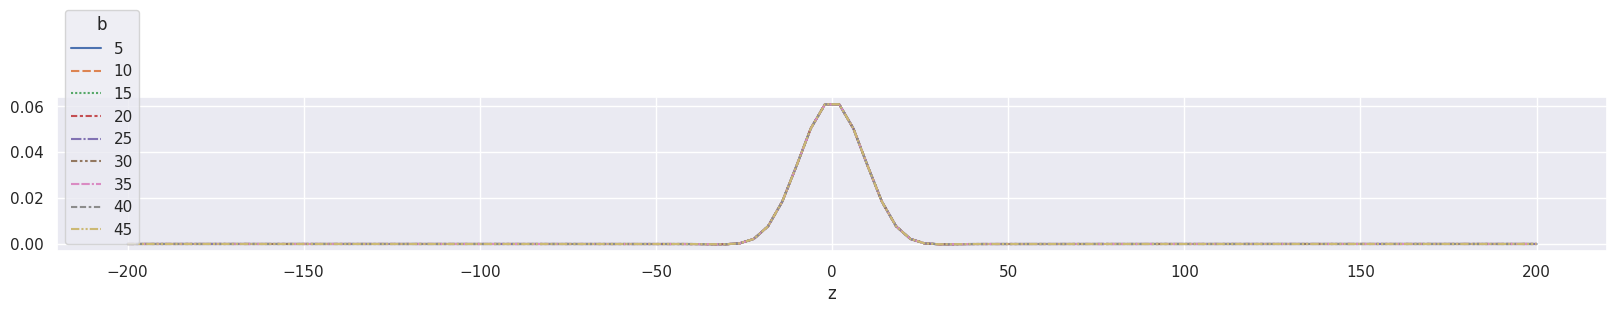

In [10]:
sns.lineplot(data=ht.pivot(index="z", columns="b", values="root"))

THe table above shows that most of the mass of $h$ is in the interval $[-30,30]$. Due to the behaviour of the QUADPACK integration method, this means that it is better to integrate while keeping $b$ inside these bounds

# Visualization Class

In [11]:
def build_observation(k: int, b: float, z: float) -> Dict[str, float]:
    return (
        k,
        b,
        z,
        H(t=0.25, z=z, k=k, b=b)[0],  # value
        H(t=0.25, z=z, k=k, b=b)[1],  # error
    )


class VisualizeDataFrame:
    def __init__(
        self, t: float, k_array: List[int], z_array: List[float], b_array: List[float]
    ):
        """
        Initializes the data to visualize

        :param t: The time we using as a starting point
        :param k_array: The number of elements in the sum to take
        :param z_array: The input to the function H(z)
        :param b_array: We take the integral between 0 and b
        """
        self.t, self.k_array, self.z_array, self.b_array = t, k_array, z_array, b_array

        self.df = create_pandas_dataframe(
            func=build_observation,
            iterable=itertools.product(k_array, b_array, z_array),
            columns=["k", "b", "z", "h", "error"],
            total=len(k_array) * len(b_array) * len(z_array),
        )

        self.df["logerror"] = [math.log(e, 10) for e in self.df["error"]]
        self.df["sign"] = [np.sign(h) for h in self.df["h"]]

    def lineplot(self, crop: None | float = None):
        # Crops the "h" value at +/- crop
        if crop is not None:
            self.df["clipped_h"] = np.clip(self.df["h"], -1 * crop, crop)

        sns.lineplot(
            x="z", y="h" if crop is None else "clipped_h", hue="b", data=self.df
        )
        if "clipped_h" in self.df.columns.values:
            self.df.drop("clipped_h", axis=1)

    def signplot(self):
        fig, ax = plt.subplots(figsize=(20, 1))
        sns.lineplot(x="z", y="sign", hue="b", data=self.df, ax=ax)

# Building the relevant data

In [12]:
interval = 1000
n_samples = 50000
z_array = np.linspace(-1 * interval, 1 * interval, n_samples)
print(f"Spacing between observations: {np.divide(2*interval, n_samples):.3f}")
results = VisualizeDataFrame(
    t=0.25, k_array=[50], b_array=[50], z_array=z_array  # [2**i for i in range(5)]
)

Spacing between observations: 0.040


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


/tmp/ipykernel_34978/3165795679.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  function = lambda u: h(t, u, z, k)


  0%|          | 0/50000 [00:00<?, ?it/s]

Process ForkPoolWorker-7:


Process ForkPoolWorker-10:


Process ForkPoolWorker-11:


Process ForkPoolWorker-9:


Process ForkPoolWorker-15:


Process ForkPoolWorker-2:


Process ForkPoolWorker-6:


Process ForkPoolWorker-5:


Process ForkPoolWorker-8:


Process ForkPoolWorker-13:


Process ForkPoolWorker-14:


Process ForkPoolWorker-3:


Process ForkPoolWorker-12:


Process ForkPoolWorker-16:


Process ForkPoolWorker-1:


Process ForkPoolWorker-4:


KeyboardInterrupt: 

# Plotting $H_{0.25}(z)$

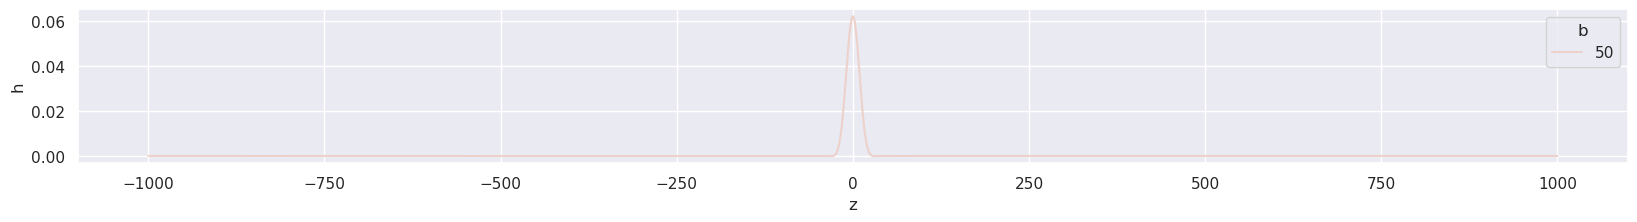

In [13]:
results.lineplot()

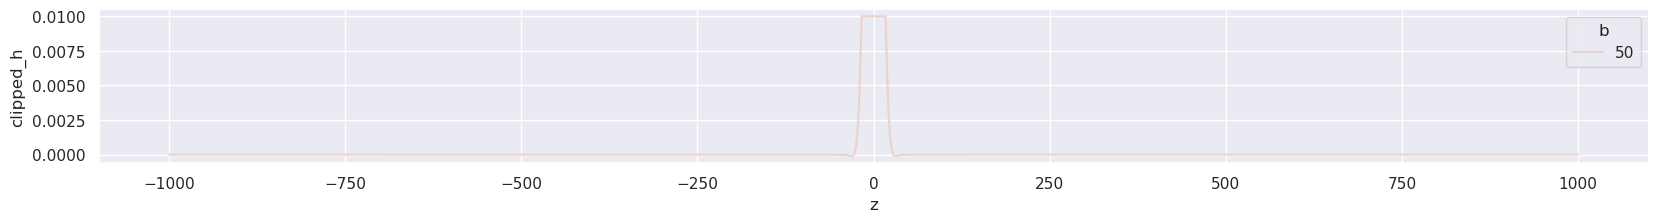

In [14]:
results.lineplot(crop=10**-2)

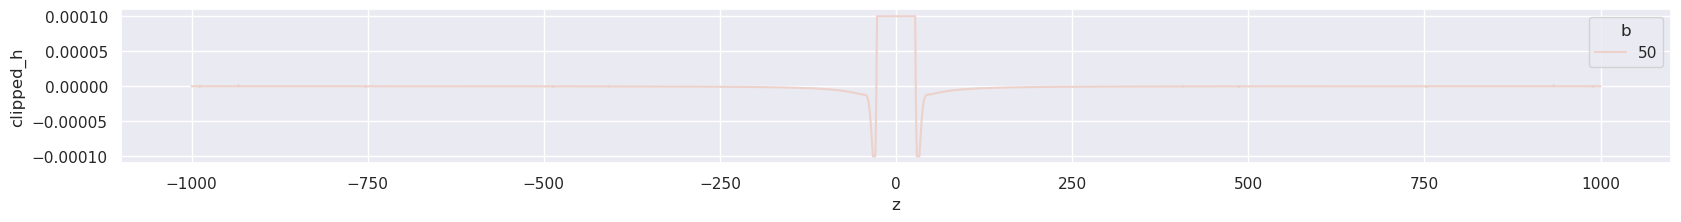

In [15]:
results.lineplot(crop=10**-4)

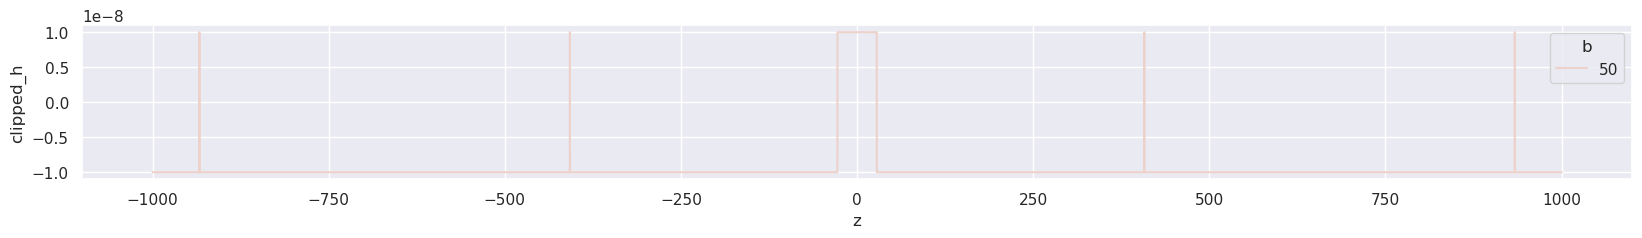

In [16]:
results.lineplot(crop=10**-8)

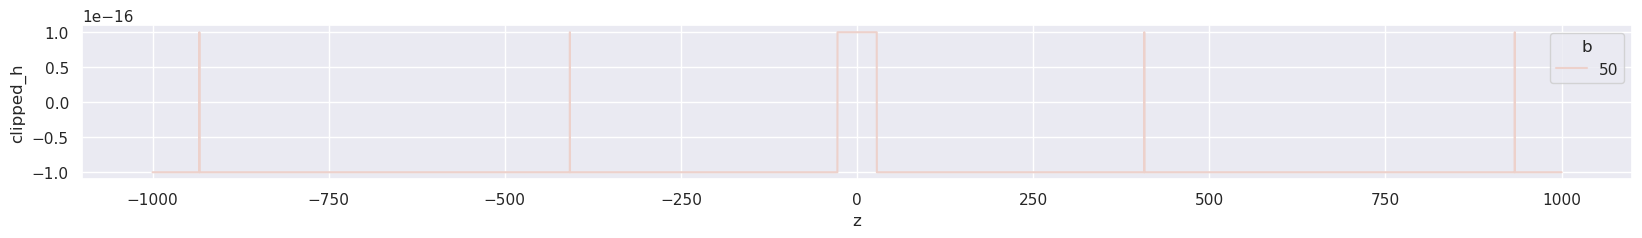

In [17]:
results.lineplot(crop=10**-16)

# Visualizing the sign of $h$

- The location of zeroes become easier to observe: we have a zero whenever the sign of $h$ swaps, as seen below.
- The zeroes are not clear from the image above.

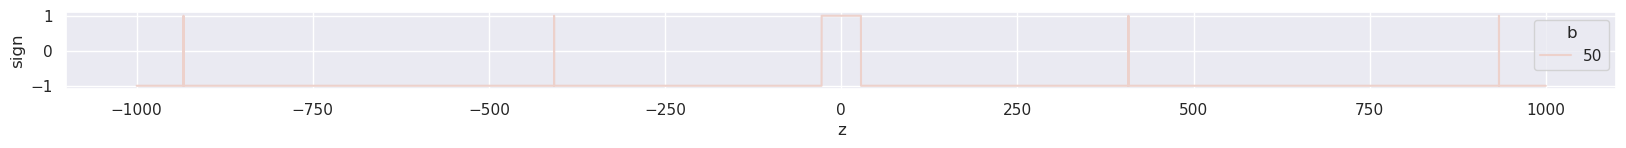

In [18]:
results.signplot()

The zeroes above are unreliable: we calculated this function using a small $k$ and integrating $h$ only on $\int_0^{b}$ . They are merely a starting point for finding the zeroes

# Finding zeroes

For
1. a time $t$
2. a given upper limit $b$ for the integral, i.e. $\int_0^b$.
3. number of elements $k$ used in the sum, i.e. $\sum_{n=1}^k$

We pass a function uni-variate $H(z)$ to scipy's root finder [fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html), in order to find roots $r$ of the function. We build the dataframe of triplets $(b,h,r_{b,k})$, and plot it to get an overview of the numerical stability of $r$.

In [19]:
k_values = [5, 20, 50]
b_values = np.linspace(5, 50, 100)
data = []


def create_zeroes_row(k, b):
    return (k, b, fsolve(func=lambda z: H(z=z, t=0.25, b=b, k=k)[0], x0=1)[0])


zeroes_df = create_pandas_dataframe(
    func=create_zeroes_row,
    columns=["k", "b", "root"],
    iterable=itertools.product(k_values, b_values),
    total=len(k_values) * len(b_values),
)

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_95379/1141751485.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(
/tmp/ipykernel_95379/1141751485.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be u

# Plots

## Histplot

<Axes: xlabel='root', ylabel='Count'>

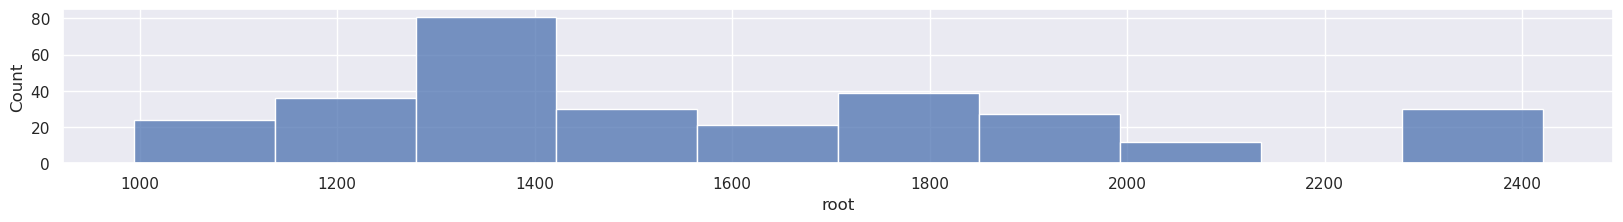

In [20]:
sns.histplot(zeroes_df["root"])

## Heatmap

In [21]:
# https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.background_gradient.html
zeroes_df.pivot(index="k", columns="b", values="root").style.background_gradient(
    cmap="viridis", axis=None
)

b,5.000000,5.454545,5.909091,6.363636,6.818182,7.272727,7.727273,8.181818,8.636364,9.090909,9.545455,10.000000,10.454545,10.909091,11.363636,11.818182,12.272727,12.727273,13.181818,13.636364,14.090909,14.545455,15.000000,15.454545,15.909091,16.363636,16.818182,17.272727,17.727273,18.181818,18.636364,19.090909,19.545455,20.000000,20.454545,20.909091,21.363636,21.818182,22.272727,22.727273,23.181818,23.636364,24.090909,24.545455,25.000000,25.454545,25.909091,26.363636,26.818182,27.272727,27.727273,28.181818,28.636364,29.090909,29.545455,30.000000,30.454545,30.909091,31.363636,31.818182,32.272727,32.727273,33.181818,33.636364,34.090909,34.545455,35.000000,35.454545,35.909091,36.363636,36.818182,37.272727,37.727273,38.181818,38.636364,39.090909,39.545455,40.000000,40.454545,40.909091,41.363636,41.818182,42.272727,42.727273,43.181818,43.636364,44.090909,44.545455,45.000000,45.454545,45.909091,46.363636,46.818182,47.272727,47.727273,48.181818,48.636364,49.090909,49.545455,50.000000
k,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1361.024832,2389.892369,1798.088664,2002.720975,1751.794880,1642.584436,1797.788024,1746.261815,1177.508689,1359.196589,1882.709164,1360.128609,2397.974675,2389.893192,2305.592547,1798.088664,1499.215233,1967.463656,1915.373550,1751.581720,1924.751752,1649.899946,994.126758,1322.178021,1933.359483,1200.653760,1572.732125,1177.562752,1684.023684,1317.621008,1287.462659,1328.954005,1219.886320,1188.587124,1384.220720,2420.836402,1784.336701,2011.737586,1369.117230,2309.926288,2307.607458,2072.022182,1448.826177,1499.215288,1283.173293,1995.205538,1469.346246,1636.701206,1846.292730,1751.558765,1476.219514,1744.105851,1477.593033,1735.487526,1391.107147,994.125939,1315.767217,1283.478351,1356.826966,1234.564784,1329.085737,1140.491602,1114.734715,1225.386985,1482.211613,1177.562752,1600.581967,1670.791957,1143.959891,1317.621008,1122.235931,1151.898718,1095.075252,1328.973735,1119.285963,1181.789465,1895.643321,1074.306106,1386.140365,1384.219304,1305.150714,1406.227601,1090.439681,1782.953306,2324.243694,1973.610210,1442.049777,1359.446743,1438.410748,2309.925962,1800.077074,1857.475324,2310.304252,1420.832607,1367.374626,1322.849022,1487.258451,1898.739975,1294.914317,1283.173293
20,1361.024832,2389.892369,1798.088664,2002.720975,1751.794880,1642.584436,1797.788024,1746.261815,1177.508689,1359.196589,1882.709164,1360.128609,2397.974675,2389.893192,2305.592547,1798.088664,1499.215233,1967.463656,1915.373550,1751.581720,1924.751752,1649.899946,994.126758,1322.178021,1933.359483,1200.653760,1572.732125,1177.562752,1684.023684,1317.621008,1287.462659,1328.954005,1219.886320,1188.587124,1384.220720,2420.836402,1784.336701,2011.737586,1369.117230,2309.926288,2307.607458,2072.022182,1448.826177,1499.215288,1283.173293,1995.205538,1469.346246,1636.701206,1846.292730,1751.558765,1476.219514,1744.105851,1477.593033,1735.487526,1391.107147,994.125939,1315.767217,1283.478351,1356.826966,1234.564784,1329.085737,1140.491602,1114.734715,1225.386985,1482.211613,1177.562752,1600.581967,1670.791957,1143.959891,1317.621008,1122.235931,1151.898718,1095.075252,1328.973735,1119.285963,1181.789465,1895.643321,1074.306106,1386.140365,1384.219304,1305.150714,1406.227601,1090.439681,1782.953306,2324.243694,1973.610210,1442.049777,1359.446743,1438.410748,2309.925962,1800.077074,1857.475324,2310.304252,1420.832607,1367.374626,1322.849022,1487.258451,1898.739975,1294.914317,1283.173293
50,1361.024832,2389.892369,1798.088664,2002.720975,1751.794880,1642.584436,1797.788024,1746.261815,1177.508689,1359.196589,1882.709164,1360.128609,2397.974675,2389.893192,2305.592547,1798.088664,1499.215233,1967.463656,1915.373550,1751.581720,1924.751752,1649.899946,994.126758,1322.178021,1933.359483,1200.653760,1572.732125,1177.562752,1684.023684,1317.621008,1287.462659,1328.954005,1219.886320,1188.587124,1384.220720,2420.836402,1784.336701,2011.737586,1369.117230,2309.926288,2307.607458,2072.022182,

# TESTS TO DO

- [ ] Use fsolve with more/less than the actual number of existing roots.